<a href="https://colab.research.google.com/github/Akankshaaaa/twitter-sentiment-analysis/blob/main/sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Twitter Sentiment Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

##Read the data
Let's have a look at out dataset and observe the different parameters.

In [3]:
data = pd.read_csv("/content/drive/MyDrive/training.csv", encoding='latin-1')
data.columns = ["label", "time", "date", "query", "username", "text"]
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [5]:
#the columns in the dataset
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [6]:
#number of records in the dataset
len(data)

1599999

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

In [9]:
#check for any null values
np.sum(data.isnull().any(axis = 1))

0

##Data Preprocessing

In [10]:
#fetching the text and labels
data = data[['text','label']]

In [11]:
#Assigning 1 to positive sentiment 4
data['label'][data['label']==4]=1

In [12]:
#seperating poisitve and negative sentiments
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [13]:
#just working with 20K records for easy computation
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [14]:
data = pd.concat([data_pos, data_neg])

In [15]:
#lower text
data['text'] = data['text'].str.lower()

###Stopword removal

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [17]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [18]:
STOPWORDS = set(stopwords.words('english'))

def cleaning_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

###Removing punctuations

In [19]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
  translator = str.maketrans('', '', punctuations_list)
  return text.translate(translator)

In [20]:
data['text'] = data['text'].apply(lambda text: cleaning_punctuations(text))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

###Removing repeating characters

In [21]:
def cleaning_repeating_char(text):
  return re.sub(r'(.)\1+', r'\1', text)

In [22]:
data['text'] = data['text'].apply(lambda text: cleaning_repeating_char(text))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

###Removing emails

In [23]:
def cleaning_email(data):
  return re.sub('@[^\s]+', ' ', data)

In [24]:
data['text'] = data['text'].apply(lambda text: cleaning_email(text))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

###Removing URLs

In [25]:
def cleaning_URLs(data):
  return re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', data)

In [26]:
data['text'] = data['text'].apply(lambda text: cleaning_URLs(text))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

###Removing numbers

In [27]:
def cleaning_numbers(data):
  return re.sub('[0-9]+', ' ', data)

In [28]:
data['text'] = data['text'].apply(lambda text: cleaning_numbers(text))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather  god thing find none ones like come si...
Name: text, dtype: object

###Performing tokenization on the text

In [29]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [30]:
data['text'].head()

799999           [love, health, uandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

###Performing stemming on the text

In [31]:
st = nltk.PorterStemmer()

def stemming_text(data):
  text = [st.stem(word) for word in data]
  return data

data['text'] = data['text'].apply(lambda x: stemming_text(x))


In [32]:
data['text'].head()

799999           [love, health, uandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

###Performing Lemmatization on the text

In [33]:
lm = nltk.WordNetLemmatizer()

def lemmatizer_text(data):
  text = [lm.lemmatize(word) for word in data]
  return data

data['text'].head()

799999           [love, health, uandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

##Training

In [34]:
#seperating input features and label
X=data.text
y=data.label


In [35]:
#preparing the input for training
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)

#convert text to arrays
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [36]:
#training and testing data split
#70% for training and 30% for testing
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)


###The model


In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model

#since we are using just 2 classes, we are using binary_crossentropy
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


In [ ]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data


Epoch 1/6
315/315 [==============================] - 43s 121ms/step - loss: 0.5726 - accuracy: 0.6957 - val_loss: 0.5211 - val_accuracy: 0.7386
Epoch 2/6
315/315 [==============================] - 37s 118ms/step - loss: 0.5118 - accuracy: 0.7531 - val_loss: 0.5310 - val_accuracy: 0.7439
Epoch 3/6
315/315 [==============================] - 37s 117ms/step - loss: 0.5040 - accuracy: 0.7537 - val_loss: 0.5269 - val_accuracy: 0.7450
Epoch 4/6
315/315 [==============================] - 37s 119ms/step - loss: 0.4797 - accuracy: 0.7665 - val_loss: 0.5184 - val_accuracy: 0.7486
Epoch 5/6
315/315 [==============================] - 31s 100ms/step - loss: 0.4754 - accuracy: 0.7721 - val_loss: 0.5236 - val_accuracy: 0.7489
Epoch 6/6
315/315 [==============================] - 36s 116ms/step - loss: 0.4568 - accuracy: 0.7809 - val_loss: 0.5317 - val_accuracy: 0.7425


In [ ]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here


375/375 [==============================] - 13s 34ms/step - loss: 0.5226 - accuracy: 0.7447


In [ ]:
#save the model
model.save('/content/drive/MyDrive/sentiment_analyser.model')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sentiment_analyser.model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/sentiment_analyser.model/assets


In [37]:
#load previous model
model = tf.keras.models.load_model(
    '/content/drive/MyDrive/sentiment_analyser.model',
    custom_objects=None,
    compile=True)

##Testing

In [38]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)


###Confusion Matrix

confusion matrix


[[4421 1588]
 [1476 4515]]




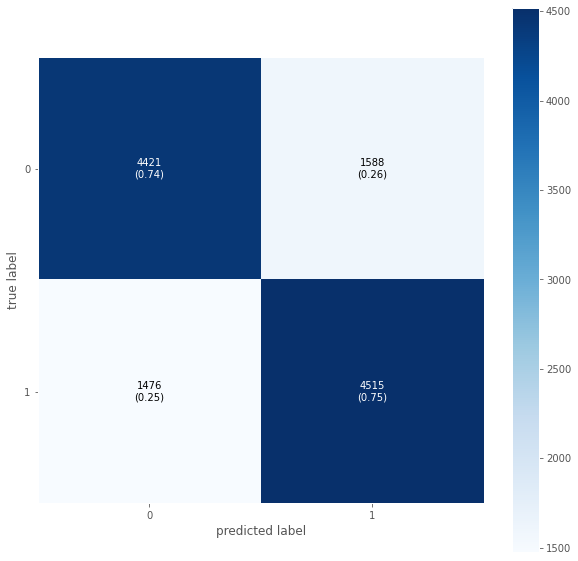

In [39]:
print('confusion matrix')
print('\n')
CR = confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat = CR, figsize = (10,10),
                                show_absolute = True,
                                show_normed = True,
                                colorbar = True)

plt.show()

In [53]:

def preprocess_text(some_text):
  some_text = cleaning_stopwords(some_text)
  some_text = cleaning_punctuations(some_text)
  some_text = cleaning_repeating_char(some_text)
  some_text = cleaning_email(some_text)
  some_text = cleaning_URLs(some_text)
  some_text = cleaning_numbers(some_text)
  some_text = tokenizer.tokenize(some_text)
  some_text = stemming_text(some_text)
  some_text = lemmatizer_text(some_text)
  return some_text

###Testing on random tweets

In [60]:
# test_text = " @yomiah is upset that he can't update his Facebook by texting it... and might cry as a result of School today also. Blah!"
# test_text = "I really don't feel like going to school today. Classes are so boring. I can't take it anymore!"
# test_text = "I love to go on walks with you @dododolan"
test_text = "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."

test_text = preprocess_text(test_text)
test_text

['nationwideclas',
 'no',
 'behaving',
 'al',
 'im',
 'mad',
 'here',
 'I',
 'cant',
 'se',
 'there']

In [61]:
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(test_text)
test_test = tok.texts_to_sequences(test_text)
test_test = sequence.pad_sequences(test_test,maxlen=500)

test_pred = model.predict(test_test)
test_pred = (test_pred > 0.5)


res = any(not i for i in test_pred)
if res:
  print("The sentiment is negative")
else:
  print("The sentiment is positive")



The sentiment is negative
